In [2]:
import torch
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

from util.facenet_model import model
from util.facenet_util import prepare_image, CLASSES_FILES, face_classes


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.load_state_dict(torch.load("facenet_classifier.pth", map_location=device))
model.eval()

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [4]:
from torchvision import transforms
from PIL import Image
import os

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
])

def prepare_image(device, image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)
    return image

def get_image_for_classes(dir, classes):
    class_files = {}
    for c in classes:
        class_files[c] = []

    for fname in sorted(os.listdir(dir)):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            name_without_ext = fname.rsplit('.', 1)[0]
            parts = name_without_ext.split('@')
            label = '@'.join(parts[:2])
            if label in classes:
                class_files[label].append(os.path.join(dir, fname))
    return class_files

face_classes = ['101506130@N03_identity_0',
 '102962858@N03_identity_2',
 '105391338@N08_identity_0',
 '105546346@N08_identity_2',
 '105700383@N05_identity_7']

CLASSES_FILES = get_image_for_classes('data/', face_classes)


In [5]:
def gradcam_method(model, input_image, target_class, target_layer_name='block8'):
    model.eval()
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations["value"] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients["value"] = grad_out[0].detach()

    target_layer = dict(model.named_modules())[target_layer_name]
    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_backward_hook(backward_hook)

    output = model(input_image)
    class_score = output[0, target_class]

    model.zero_grad()
    class_score.backward()

    grads = gradients["value"]
    acts = activations["value"]

    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * acts).sum(dim=1, keepdim=True)
    cam = F.relu(cam)
    cam = F.interpolate(cam, size=(input_image.shape[2], input_image.shape[3]), mode='bilinear', align_corners=False)
    cam = cam.squeeze().cpu()

    cam -= cam.min()
    cam /= cam.max()

    handle_fw.remove()
    handle_bw.remove()

    return output, cam

In [6]:
def plot_gradcam(input_image, cam):
    image_np = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
    heatmap = cam.numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_np, alpha=0.6)
    plt.imshow(heatmap, cmap='jet', alpha=0.4)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

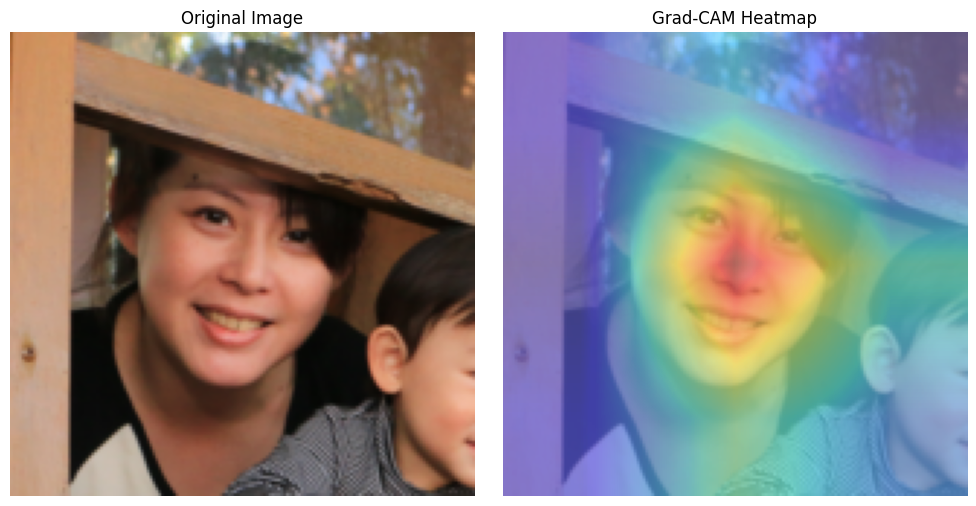

In [13]:

image_path = CLASSES_FILES[face_classes[0]][3]
input_image = prepare_image(device, image_path)
output = model(input_image)
predicted_class = output.argmax(dim=1).item()

_, cam = gradcam_method(model, input_image, target_class=predicted_class, target_layer_name='block8')
plot_gradcam(input_image, cam)


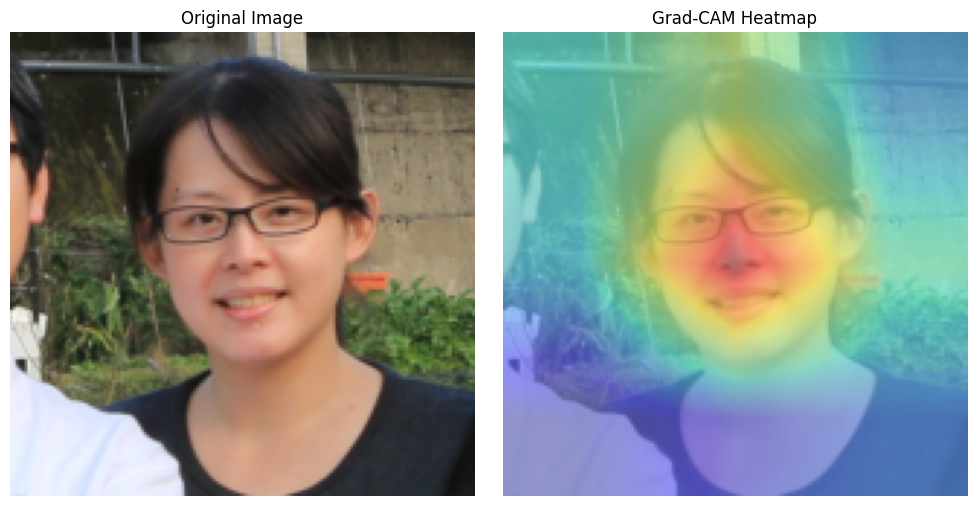

In [8]:
image_path = CLASSES_FILES[face_classes[0]][2]
input_image = prepare_image(device, image_path)
output = model(input_image)
predicted_class = output.argmax(dim=1).item()

_, cam = gradcam_method(model, input_image, target_class=predicted_class, target_layer_name='block8')
plot_gradcam(input_image, cam)


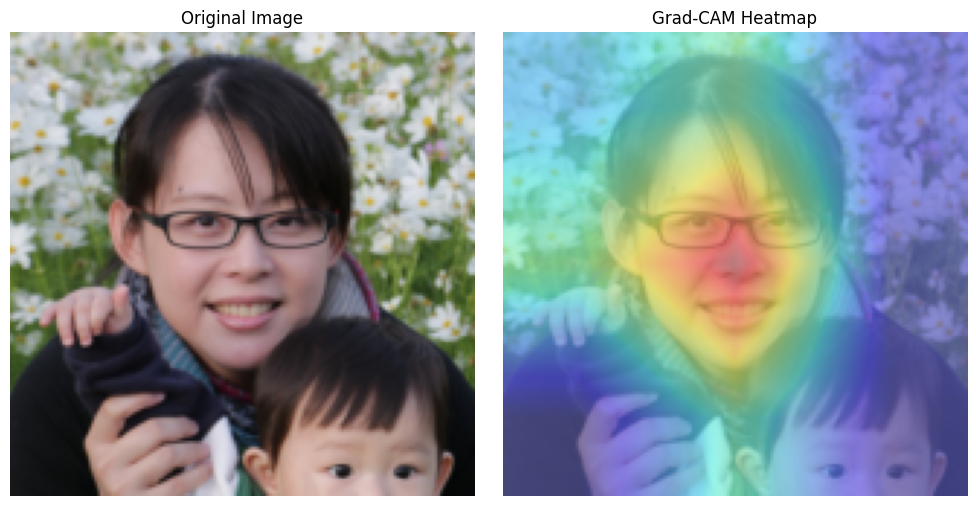

In [9]:
image_path = CLASSES_FILES[face_classes[0]][0]
input_image = prepare_image(device, image_path)
output = model(input_image)
predicted_class = output.argmax(dim=1).item()
_, cam = gradcam_method(model, input_image, target_class=predicted_class, target_layer_name='block8')
plot_gradcam(input_image, cam)

In [11]:

DAUC = "DAUC"
IAUC = "IAUC"
DELETION = "Deletion"
INSERTION = "Insertion"

@dataclass
class CorrMetricsParams:
    perturbed_image: Callable
    mask: Callable
    label: str

def cloned_image(input_image):
    return input_image.clone()

def zeros_image(input_image):
    return torch.zeros_like(input_image)

def mask_set_zero(abs_relevance, num_remove, sorted_indices):
    mask = torch.ones_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_remove]] = 0
    return mask

def mask_set_one(abs_relevance, num_add, sorted_indices):
    mask = torch.zeros_like(abs_relevance.view(-1))
    mask[sorted_indices[:num_add]] = 1
    return mask

del_corr = CorrMetricsParams(
    perturbed_image=cloned_image,
    mask=mask_set_zero,
    label="removed"
)

ins_corr = CorrMetricsParams(
    perturbed_image=zeros_image,
    mask=mask_set_one,
    label="added"
)

metrics_params = {
    DAUC: True,
    IAUC: False,
    DELETION: del_corr,
    INSERTION: ins_corr,
}

def apply_mask(input_image, mask, abs_relevance):
    mask = mask.view(abs_relevance.shape).unsqueeze(0).repeat(3, 1, 1)
    return input_image * mask

def get_abs_relevance(relevance):
    if relevance.dim() == 3:
        return relevance.abs().sum(0)
    elif relevance.dim() == 2:
        return relevance.abs()
    else:
        raise ValueError("Unsupported relevance shape for Grad-CAM or LRP.")

def get_num_pixels(input_image):
    return input_image.shape[2] * input_image.shape[3]

def compute_auc(model, input_image, output, relevance, auc, steps=10, plot=False):
    model.eval()
    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=metrics_params[auc])
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            score = model(perturbed_image)
        perturbation_curve.append(score.max().item())

    x_vals = np.linspace(0, 1, steps)
    auc_value = np.trapz(perturbation_curve, x_vals)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel("Fraction of pixels occluded")
        plt.ylabel("Model Output Score")
        plt.title(f"{auc} Evaluation (AUC = {auc_value:.4f})")
        plt.legend()
        plt.show()

    return auc_value, perturbation_curve

def compute_ins_del_correlation(model, input_image, output, relevance, corr, steps=10, plot=False):
    model.eval()
    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)
    perturbed_image = metrics_params[corr].perturbed_image(input_image)
    perturbation_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = metrics_params[corr].mask(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            score = model(perturbed_image)
        perturbation_curve.append(score.max().item())

    x_vals = np.linspace(0, 1, steps)
    correlation, _ = pearsonr(x_vals, perturbation_curve)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(x_vals, perturbation_curve, marker='o', label="Score Drop")
        plt.xlabel(f"Fraction of pixels {metrics_params[corr].label}")
        plt.ylabel("Model Output Score")
        plt.title(f"{corr} Correlation = {correlation:.4f}")
        plt.legend()
        plt.show()

    return correlation

def compute_average_drop(model, input_image, output, relevance, steps=10, plot=False):
    model.eval()
    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)
    drop_curve = []
    initial_score = model(input_image).max().item()
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_remove = int((step / steps) * num_pixels)
        mask = mask_set_zero(abs_relevance, num_remove, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            score = model(perturbed_image)
        drop = initial_score - score.max().item()
        drop_curve.append(drop)

    average_drop = np.mean(drop_curve)

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), drop_curve, marker='o', label="Output Drop")
        plt.xlabel("Fraction of pixels removed")
        plt.ylabel("Drop in model output")
        plt.title(f"Average Drop = {average_drop:.4f}")
        plt.legend()
        plt.show()

    return average_drop

def compute_increase_in_confidence(model, input_image, output, relevance, steps=10, plot=False):
    model.eval()
    abs_relevance = get_abs_relevance(relevance)
    sorted_indices = abs_relevance.view(-1).argsort(descending=True)
    perturbed_image = zeros_image(input_image)
    confidence_curve = []
    num_pixels = get_num_pixels(input_image)

    for step in range(1, steps + 1):
        num_add = int((step / steps) * num_pixels)
        mask = mask_set_one(abs_relevance, num_add, sorted_indices)
        perturbed_image = apply_mask(input_image, mask, abs_relevance)

        with torch.no_grad():
            score = model(perturbed_image)
        confidence = torch.sigmoid(score.max()).item()
        confidence_curve.append(confidence)

    increase_in_confidence = confidence_curve[-1] - confidence_curve[0]

    if plot:
        plt.figure(figsize=(6, 4))
        plt.plot(np.linspace(0, 1, steps), confidence_curve, marker='o', label="Confidence")
        plt.xlabel("Fraction of pixels added")
        plt.ylabel("Confidence")
        plt.title(f"Increase in Confidence = {increase_in_confidence:.4f}")
        plt.legend()
        plt.show()

    return increase_in_confidence


In [12]:
iauc_value, _ = compute_auc(model, input_image, output, cam, auc=IAUC, steps=10)
print(f"IAUC Score: {iauc_value:.4f}")

dauc_value, _ = compute_auc(model, input_image, output, cam, auc=DAUC, steps=10)
print(f"DAUC Score: {dauc_value:.4f}")

insertion_correlation = compute_ins_del_correlation(model, input_image, output, cam, corr=INSERTION, steps=10)
print(f"Insertion Correlation: {insertion_correlation:.4f}")

deletion_correlation = compute_ins_del_correlation(model, input_image, output, cam, corr=DELETION, steps=10)
print(f"Deletion Correlation: {deletion_correlation:.4f}")

average_drop = compute_average_drop(model, input_image, output, cam, steps=10)
print(f"Average Drop: {average_drop:.4f}")

increase_in_confidence = compute_increase_in_confidence(model, input_image, output, cam, steps=10)
print(f"Increase in Confidence: {increase_in_confidence:.4f}")


IAUC Score: 5.0953
DAUC Score: 0.5338
Insertion Correlation: 0.8222
Deletion Correlation: -0.6122
Average Drop: 5.5181
Increase in Confidence: 0.0389
